<a href="https://colab.research.google.com/github/LUMII-AILab/NLP_Course/blob/main/notebooks/HFST_en_and_more.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite state automata and transducers for morphology

Helsinki Finite State Transdusers (HFST)

Based on: https://github.com/hfst/compmorph-course/

In [ ]:
!pip install hfst
# !pip install hfst_dev
#!pip install graphviz

In [ ]:
import hfst
# import hfst_dev
#import graphviz
from IPython.display import Image

In [ ]:
# help(hfst)
# help(hfst.compile_lexc_file)
# help(hfst.compile_twolc_file)

## A Finite-State Transducer that implements a morphological generator

### Simple English paradigms
For more informations see: [COMPUTATIONAL MORPHOLOGY WITH HFST TOOLS - LECTURE 1](https://github.com/hfst/compmorph-course/blob/main/Lecture1/Lecture.ipynb)
```
Paradigm: N
cat	+Sg (singular)
cat|s	+Pl (plural)
cat|'s	+Sg +Poss (singular possessive)
cat|s'	+Pl +Poss (plural possessive)
Similarly: dog, pet, book, hill, fan

Paradigm: N_s
(The understroke following the part-of-speech marker N with a subsequent mnemonic 's' is a transparent way of indicating allomorphic inflection types.)

kiss	+Sg (singular)
kiss|es	+Pl (plural)
kiss|'s	+Sg +Poss (singular possessive)
kiss|es|'	+Pl +Poss (plural possessive)
Similarly: wish, mess, church, search, waitress


Paradigm: N_y
The noun lexica N_y are used for stems with "y" -> "ie" alternation

sky	+Sg (singular)
sky|s	+Pl (plural)
sky|'s	+Sg +Poss (singular possessive)
sky|s'	+Pl +Poss (plural possessive)


```



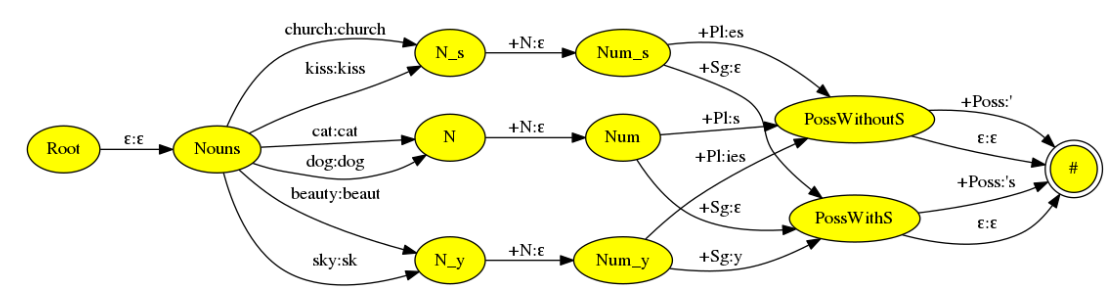


### Lexicon (lexc code)
Define all symbols consisting of multiple characters

```
Multichar_Symbols
        +N      ! Noun tag
        +Sg     ! Singular
        +Pl     ! Plural
        +Poss   ! Possessive form
                ! Another comment that is ignored by the compiler
Anything between an exclamation mark and the end of a line is a comment. Comments are ignored by the lexc compiler. Use comments a lot! Your code will be clearer to yourself and to others.

```

Define the compulsory Root lexicon
```
LEXICON Root
        Nouns ; ! No input, no output
```


Define the Nouns lexicon

```
!
! NOUNS start here
!

LEXICON Nouns

cat     N ;
dog     N ;

church  N_s ;
kiss    N_s ;

beauty:beaut    N_y ;
sky:sk          N_y ;

```



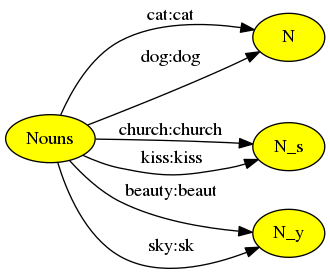

#### Continuation lexicons for the N paradigm

```

! The noun lexica N and Num are used for stems without
! any alternation

LEXICON N
+N:0    Num ;

LEXICON Num
+Sg:0   PossWithS ;
+Pl:s   PossWithoutS ;
```
#### Continuation lexicons for the N_s paradigm
```
! The noun lexica N_s and Num_s are used for stems that
! end in a sibilant and need an extra inserted "e"

LEXICON N_s
+N:0    Num_s ;

LEXICON Num_s
+Sg:0   PossWithS ;
+Pl:es  PossWithoutS ;
```

####Continuation lexicons for the N_y paradigm
```
! The noun lexica N_y and Num_y are used for stems with
! "y" -> "ie" alternation

LEXICON N_y
+N:0    Num_y ;

LEXICON Num_y
+Sg:y   PossWithS ;
+Pl:ies PossWithoutS ;
```

####Continuation lexicons for possessive marker
```
! Possessive markers: usually the singular is 's and
! the plural is '

LEXICON PossWithS
+Poss:'s    # ;
            # ; ! No ending: no input/output

LEXICON PossWithoutS
+Poss:'     # ;
            # ; ! No ending: no input/output


```

## Compiling lexicon script into a transducer

In [ ]:
# Upload from repository
#!wget https://raw.githubusercontent.com/LUMII-AILab/NLP_Course/main/notebooks/resources/HFST/Latvian.lexc
# Lexicon with palatalization
#!wget https://raw.githubusercontent.com/LUMII-AILab/NLP_Course/main/notebooks/resources/HFST/English.lexc
# Simple lexicon
!wget https://raw.githubusercontent.com/LUMII-AILab/NLP_Course/main/notebooks/resources/HFST/en_ia_morphology.lexc

In [ ]:
from hfst import compile_lexc_file
#generator = hfst.compile_lexc_file('English.lexc')
generator = hfst.compile_lexc_file('en_ia_morphology.lexc')
print(generator.lookup('sky+N+Pl'))
# print (generator)


In [ ]:
# Visualisation
# hfst2png(generator,'generator.png')
# Image('generator.png')

## Transdjūseri: divlīmeņu morfoloģija | Transducers: two-level morphology
For more information see [COMPUTATIONAL MORPHOLOGY WITH HFST TOOLS - LECTURE 2](https://github.com/hfst/compmorph-course/blob/main/Lecture2/Lecture.ipynb)


In [ ]:
# Sintēze | Synthesis
from hfst import HfstTransducer

analyzer = HfstTransducer(generator) # Create a copy

print(analyzer.lookup('sky+N+Pl'))

In [ ]:
# Analysis
# We need to invert the transducer to get an analyzer.
# After inversion, it is good to minimize the transducer
# (i.e. reduce it to an equivalent transducer with the smallest number of states).

analyzer.invert()
analyzer.minimize()

print(analyzer.lookup('skies'))

In [ ]:
# Salīdzināšana | Comparison

analyzer.invert()
analyzer.minimize()

print(analyzer.compare(generator))

## FST kaskadēšana | FST cascading


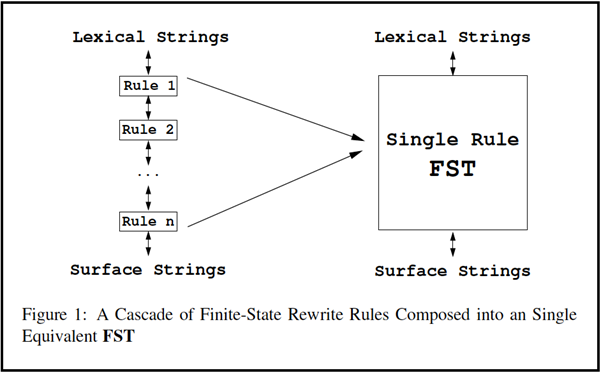

In [ ]:
from hfst import regex, HfstTransducer

### Insertion

In [ ]:
# Insertion
# Insert 'e' after the end of the stem in front of 's', if the stem ends in 's', 'x', 'ch', 'sh' or 'y'.
InsertE = regex("[. .] -> e || [ s | x | c h | s h | y ] %^ _ s")
print(InsertE.lookup("sky^s'"))

### Replacement

In [ ]:
# Replacement
# Rewrite 'y' as 'i' when followed by the end of the stem, which is further followed by 'e'.
YToI = regex("y -> i || _ %^ e")
print(YToI.lookup("sky^es'"))

### Izņēmumi

In [ ]:
# Exceptions
Exceptions = hfst.regex("g o o s e %^ s -> g e e s e ")
print(Exceptions.lookup("goose^s"))

### Removal

In [ ]:
# Deleting
# Remove the end of stem marker
# MCleanup = hfst.regex('M -> 0')
Cleanup = hfst.regex('"^" -> 0')
print(Cleanup.lookup("ski^es"))

## Cascade

In [ ]:
from hfst import compose

# Generation
print(generator.lookup("sky+N+Pl+Poss"))
cascade = compose((generator, InsertE))
print(cascade.lookup("sky+N+Pl+Poss"))
cascade = compose((generator, InsertE, YToI))
print(cascade.lookup("sky+N+Pl+Poss"))
cascade = compose((generator, InsertE, YToI, Exceptions))
print(cascade.lookup("sky+N+Pl+Poss"))
cascade = compose((generator, InsertE, YToI, Exceptions, Cleanup))
print(cascade.lookup("sky+N+Pl+Poss"))


In [ ]:
# If you use the HFST library, you will need to remove the epsilon symbol.
cascade.remove_epsilons()
print(cascade.lookup("sky+N+Pl+Poss")[0][0].replace("@_EPSILON_SYMBOL_@", ""))

In [ ]:
# Analysis
inv = hfst.HfstTransducer(cascade)
inv.invert()
inv.convert(hfst.ImplementationType.HFST_OL_TYPE)
print(inv.lookup("skies"))


## FST visualization

In [ ]:
import sys

def hfst2png(transducer, png_name):
    # Write the FST to a file using the att format
    f = open("a.att", "w", encoding="utf-8")
    transducer.minimize()
    transducer.write_att(f, False)

    # Convert the FST file to the dot format
    # dot format is used by graphviz library for graph visualization
    f = open("a.att", "r", encoding="utf-8")
    with open("graph.dot", "w", encoding="utf-8") as out_f:
        out_f.write('digraph G { rankdir="LR"\n')
        out_f.write('node [fontname="Tahoma",shape=circle,fontsize=14,fixedsize=true,fillcolor="grey",style=filled]\n')
        out_f.write('edge [fontname="FreeMono",fontsize=14]\n')
        for line in f.readlines():
            line = line.strip()
            row = line.split('\t')
            if len(row) >= 4:
                out_f.write('%s [label="%s"];\n' % (row[0], row[0]))
                out_f.write('%s -> %s [label="%s:%s"];\n' % (row[0], row[1], row[2], row[3]))
            elif len(row) == 1: # Final state
                out_f.write('%s [label="%s",shape=doublecircle];\n' % (row[0], row[0]))
        out_f.write('}')

    # Call graphviz dot function to generate a png file from dot file
    !dot -Tpng graph.dot > $png_name

In [ ]:
# Call the transformation to png on the HFSTTransducer "cascade"
hfst2png(cascade,'image.png')

In [ ]:
# Display image in notebook
# from IPython.display import Image
Image('image.png')

Printing

In [ ]:
for noun in ["cat", "dog", "sky", "kiss", "church","goose"]:
    for number in ["Sg", "Pl"]:
#        for form in ["Nom", "Gen", "Dat", "Acc", "Loc"]:
            print(noun + "+N+" + number + " - " + cascade.lookup(noun + "+N+" + number)[0][0].replace("@_EPSILON_SYMBOL_@", ""))


